In [1]:
# ================================
# Step 1: Import Libraries
# ================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import joblib

In [2]:
# ================================
# Step 2: Load and Clean Data
# ================================
df = pd.read_csv("unicorns till sep 2022.csv")

# Rename columns
df.rename(columns={
    'Company': 'Company',
    'Valuation ($B)': 'Valuation',
    'Date Joined': 'Date_Joined',
    'Country': 'Country',
    'City ': 'City',
    'Industry': 'Sector',
    'Investors': 'Investors'
}, inplace=True)

# Clean valuation column
df['Valuation'] = df['Valuation'].str.replace('$', '', regex=False).astype(float)

# Convert dates
df['Date_Joined'] = pd.to_datetime(df['Date_Joined'])
df['Month'] = df['Date_Joined'].dt.month
df['Year'] = df['Date_Joined'].dt.year

# Split investors
investors_split = df['Investors'].str.split(',', expand=True)
investors_split.columns = ['Investor_1', 'Investor_2', 'Investor_3', 'Investor_4']
df = pd.concat([df, investors_split], axis=1)

# Drop original Investors column
df.drop(columns='Investors', inplace=True)

# Handle missing values
df.fillna('None', inplace=True)

df.head()

,Company,Valuation,Date_Joined,Country,City,Sector,Month,Year,Investor_1,Investor_2,Investor_3,Investor_4
0,ByteDance,140.0,2017-04-07,China,Beijing,Artificial intelligence,4,2017,Sequoia Capital China,SIG Asia Investments,Sina Weibo,Softbank Group
1,SpaceX,127.0,2012-12-01,United States,Hawthorne,Other,12,2012,Founders Fund,Draper Fisher Jurvetson,Rothenberg Ventures,None
2,SHEIN,100.0,2018-07-03,China,Shenzhen,E-commerce & direct-to-consumer,7,2018,Tiger Global Management,Sequoia Capital China,Shunwei Capital Partners,None
3,Stripe,95.0,2014-01-23,United States,San Francisco,Fintech,1,2014,Khosla Ventures,LowercaseCapital,capitalG,None
4,Canva,40.0,2018-01-08,Australia,Surry Hills,Internet software & services,1,2018,Sequoia Capital China,Blackbird Ventures,Matrix Partners,None


In [3]:
#Checking null values
df.isnull().sum()

Company        0
Valuation      0
Date_Joined    0
Country        0
City           0
Sector         0
Month          0
Year           0
Investor_1     0
Investor_2     0
Investor_3     0
Investor_4     0
dtype: int64

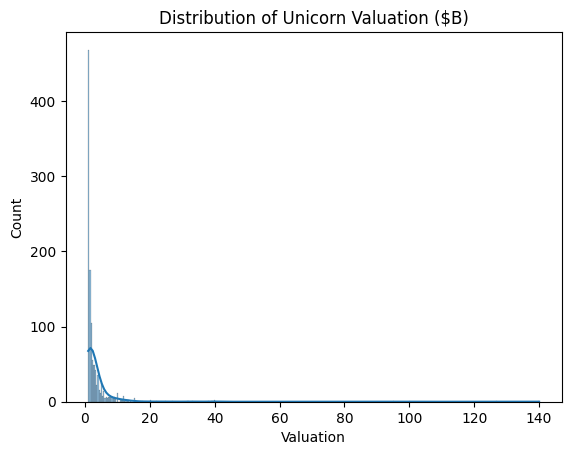

In [4]:
# ================================
# Step 3: Exploratory Data Analysis
# ================================
sns.histplot(df['Valuation'], kde=True)
plt.title("Distribution of Unicorn Valuation ($B)")
plt.show()


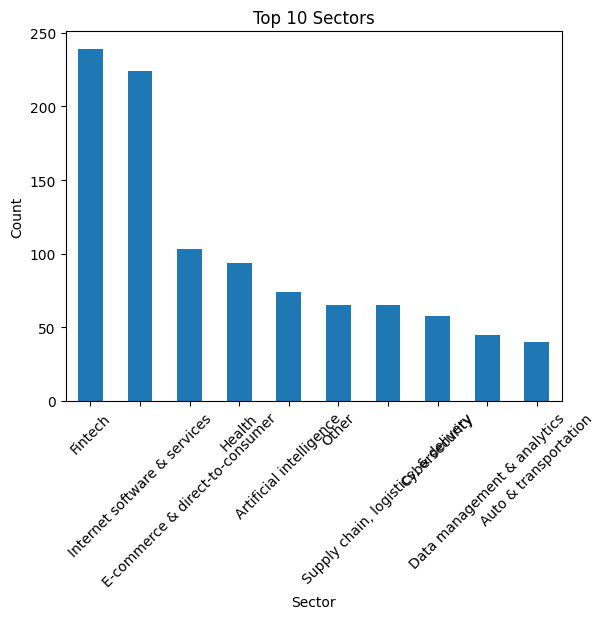

In [5]:
# Top sectors
top_sectors = df['Sector'].value_counts().head(10)
top_sectors.plot(kind='bar', title="Top 10 Sectors")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

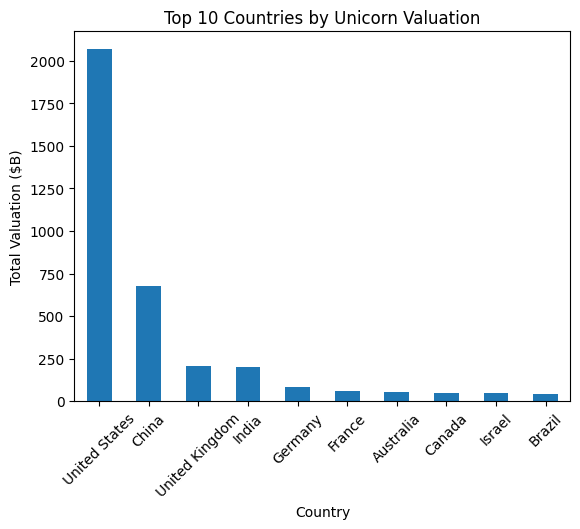

In [6]:
# Country-wise valuation
country_val = df.groupby("Country")["Valuation"].sum().sort_values(ascending=False).head(10)
country_val.plot(kind='bar', title="Top 10 Countries by Unicorn Valuation")
plt.ylabel("Total Valuation ($B)")
plt.xticks(rotation=45)
plt.show()


In [7]:
# Country analysis
analysis=round(df['Country'].value_counts(normalize=True)*100,2)
analysis


Country
United States           53.63
China                   14.67
India                    5.90
United Kingdom           3.88
Germany                  2.45
France                   2.02
Israel                   1.85
Canada                   1.60
Brazil                   1.43
South Korea              1.43
Singapore                1.10
Sweden                   0.67
Mexico                   0.67
Australia                0.67
Netherlands              0.59
Indonesia                0.59
Hong Kong                0.59
Switzerland              0.51
Ireland                  0.51
Japan                    0.51
Norway                   0.42
Spain                    0.34
Finland                  0.34
Turkey                   0.25
United Arab Emirates     0.25
Belgium                  0.25
Colombia                 0.25
Estonia                  0.17
Chile                    0.17
Vietnam                  0.17
Austria                  0.17
Denmark                  0.17
South Africa             0.17
Th

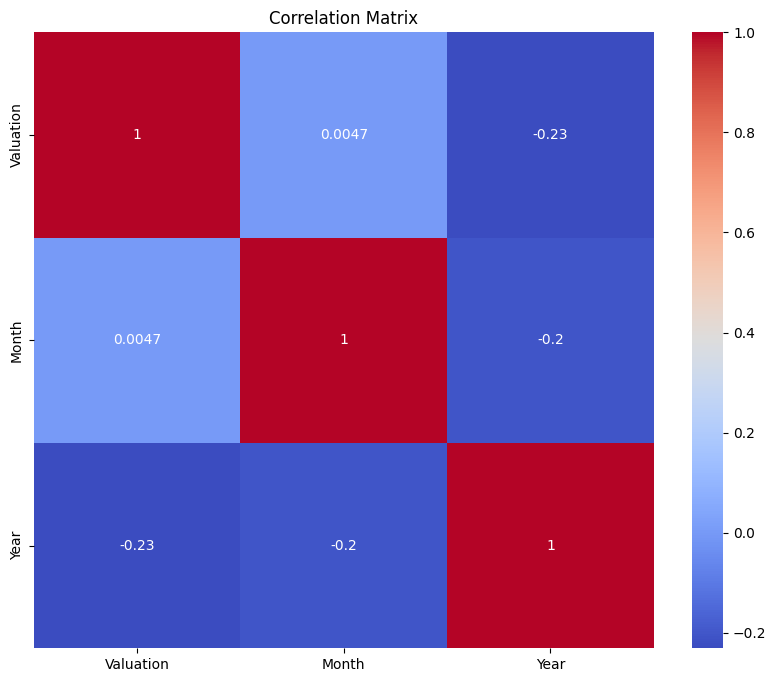

In [8]:
# Visualize correlations between features
numeric_df = df.select_dtypes(include=['number'])
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [9]:
# ================================
# Step 4: Feature Engineering
# ================================
df_encoded = pd.get_dummies(df[['Country', 'City', 'Sector', 'Year', 'Month']], drop_first=True)

X = df_encoded
y = df['Valuation']

In [10]:
# ================================
# Step 5: Train-Test Split & Scaling
# ================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
# ================================
# Step 6: Model Training
# ================================
# Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

# Random Forest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

# Evaluation
print("Linear Regression R²:", r2_score(y_test, y_pred_lr))
print("Random Forest R²:", r2_score(y_test, y_pred_rf))

Linear Regression R²: -7.0177122067605175
Random Forest R²: -4.098701315744097


In [12]:
# ================================
# Step 7: Hyperparameter Tuning
# ================================
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, verbose=1, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Best Model
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test_scaled)

print("Tuned Random Forest R²:", r2_score(y_test, y_pred_best))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Tuned Random Forest R²: -3.8080169080580157


In [13]:
# ================================
# Step 8: Save Model
# ================================
joblib.dump(best_rf, "unicorn_model.pkl")
joblib.dump(X.columns.tolist(), "model_features.pkl")

['model_features.pkl']